In [ ]:
# to stop warnings from printing later
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

# Section 1 - Modelling intracellular infection

Creating a function that calculates the matrix of transition rates, **Q**.

\begin{equation}
\frac{dM_1}{dt} = -(\alpha_1 + \mu_1) M_1 + \sum_{i \geq 1} \beta_i \mu_i M_i
\end{equation}

\begin{equation}
\forall i > 1, \quad \frac{dM_i}{dt} = (i - 1) \alpha_{i-1} M_{i-1} - (i \alpha_i + \mu_i) M_i
\end{equation}



In [ ]:
import numpy as np

def dyn_mat(alpha, mu, beta):
  N = len(alpha) # find dimmensions of matrix
  Q = np.zeros(shape=(N, N)) # initialise matrix
  # set matrix elements corresponding to dM1/dt
  Q[1][1] = -(alpha[1] + mu[1]) + beta[1]*mu[1]
  for i in range(2, N):
    Q[1][i] = beta[i]*mu[i]
  # set other matrix elements
  for j in range(2, N):
    Q[j][j-1] = (j-1)*alpha[j-1]
    Q[j][j] = -(j*alpha[j] + mu[j])
  return Q


Creating a function to solve the above system of differential equations.


In [ ]:
from scipy.integrate import solve_ivp
import time

# define function to 'set up' ODE to be solved
def tmp(t, M, alpha, mu, beta):
  return dyn_mat(alpha, mu, beta) @ M.T

# define function to solve ODE using solve_ivp from scipy.integrate
def ode_sol(alpha, mu, beta, M_0, max_time):
  times = np.linspace(0, max_time, max_time + 1)
  return solve_ivp(tmp, [times[0], times[-1]], M_0, args=(alpha, mu, beta), t_eval=times, method='LSODA')


## Model A - fixed burst size

The bacterial division rate is uniform in all cells, with mean generation time $1/r$:

$\alpha_N = 0$ and $\alpha_i = r$, $∀i < N$

• Infected cells only burst when they reach the critical threshold of N bacteria. Specifically, we
assume that a cell of size N bursts when any of the N bacteria divides, releasing N+1 bacteria.
Hence:

$\mu_N = Nr$ and $\mu_i = 0$, $∀i < N$

$\beta_N = N+1$ and $\beta_i = 0$, $∀i < N$


Using the 'ode_sol' function to calculate the numerical solution for this model, setting *r = 1* and the following values for the burst size *N* : 5, 10, 20.

Initial conditions: one macrophage infected with one bacterium at *t = 0*. For each value of *N*, separate graphs are plotted for:
- the array of variables $M_i(t)$ and the total number of infected cells $Y(t) = \sum_i M_i(t)$
- the array of proportions $P_i(t) = \frac{M_i(t)}{Y(t)}$


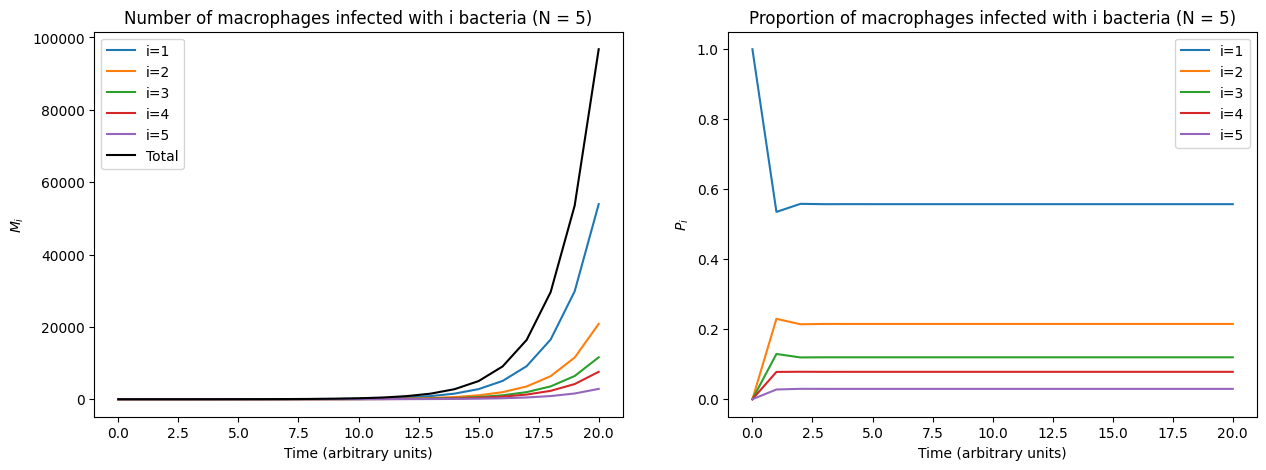

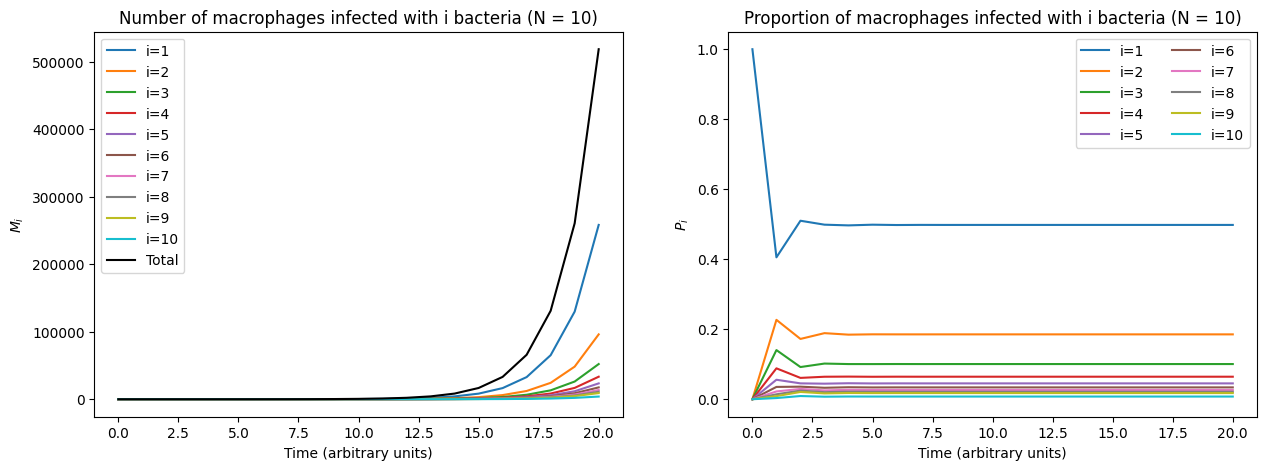

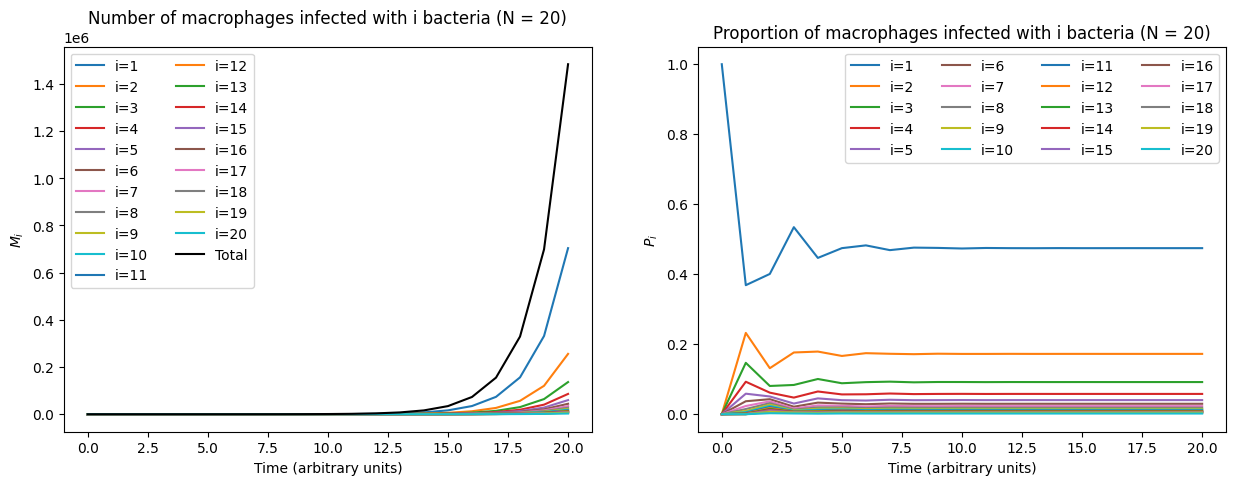

In [ ]:
import matplotlib.pyplot as plt

P_i_dict = {5: {}, 10: {}, 20: {}} # to store arrays of proportions for use in task 1.d
max_time = 20
Ns = [5, 10, 20]
for N in Ns:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  # initialise the starting condition
  M_0 = np.zeros(shape=(N+1,))
  M_0[1] = 1
  # initialise alpha vector
  alpha = np.ones(shape=(N+1,))
  alpha[0] = 0
  # initialise mu vector
  mu = np.zeros(shape=(N+1,))
  mu[N] = N
  # initialise beta vector
  beta = np.zeros(shape=(N+1,))
  beta[N] = N + 1

  # get output of ode_sol function
  Ms = ode_sol(alpha, mu, beta, M_0, max_time)

  # plot for each value of i for 1 <= i <= N
  for i in range(1, N+1):
    ax1.plot(Ms.t, Ms.y[i])

  # plot the total
  Y = []
  for j in range(len(Ms.t)):
    Y.append(sum([Ms.y[n][j] for n in range(len(Ms.y))]))
  ax1.plot(Ms.t, Y, color="black")
  ax1.set_title("Number of macrophages infected with i bacteria (N = " + str(N) + ")")
  ax1.set_xlabel("Time (arbitrary units)")
  ax1.set_ylabel(r"$M_i$")
  legend_ls = ["i=" + str(k) for k in range(1, N+1)]
  legend_ls.append("Total")
  ax1.legend(legend_ls, loc='upper left', ncols=1 if N < 12 else 2)

  # plot the proportional population of cells infected by i bacteria
  P = np.zeros(shape=len(Ms.y[0]))
  for i in range(1, N+1):
    for j in range(len(Ms.y[i])):
        P[j] = Ms.y[i][j] / Y[j]
    ax2.plot(Ms.t, P)
    P_i_dict[N][i] = P[-1] # store end value of P_i for each value of i, for each value of N (for use in task 1.d)
  ax2.set_title("Proportion of macrophages infected with i bacteria (N = " + str(N) +")")
  ax2.set_xlabel("Time (arbitrary units)")
  ax2.set_ylabel(r"$P_i$")
  ax2.legend(["i=" + str(k) for k in range(1, N+1)], loc='upper right', ncols=N//5)
  plt.show()

### Affects of burst size *N*

As can be seen in the plots above, increasing *N* increases the number of macrophage cells infected with *i* bacteria for each value of *i* {1 ≤ *i* ≤ *N*}. The proportion of macrophages infected with *i* bacteria appears to be less significantly affected, however the line corresponding to *i*=1 does reach equilibrium at a slightly lower value when *N* is increased. This difference is larger between *N*=5 and *N*=10 than between *N*=10 and *N*=20, suggesting that the proportions may tend to a value as *N* becomes very large.

The rate at which an equilibrium or 'steady state' is reached also changes as we increase *N*. For *N*=5, we see that the proportions of macrophages infected with *i* bacteria reaches a steady state almost immediately, whereas when *N*=20 it takes many more time increments.

### Testing affects of bacterial division rate *r*

Observation: the total bacterial load in the livers of infected mice grew exponentially from a mean of 250 to a
mean of $10^6$ in 4 days. We will explore how the value of *r* affects the dynamics.

Crude estimate of *r* can be obtained using the information given as follows:

$250 \cdot e^{4r} = 10^{6}$

$r = \frac{1}{4}ln(\frac{10^6}{250}) ≈ 2.07 \space (3 \space s.f.)$

Note that we now have units of days for time *t* and units of days$^{-1}$ for rate *r*.

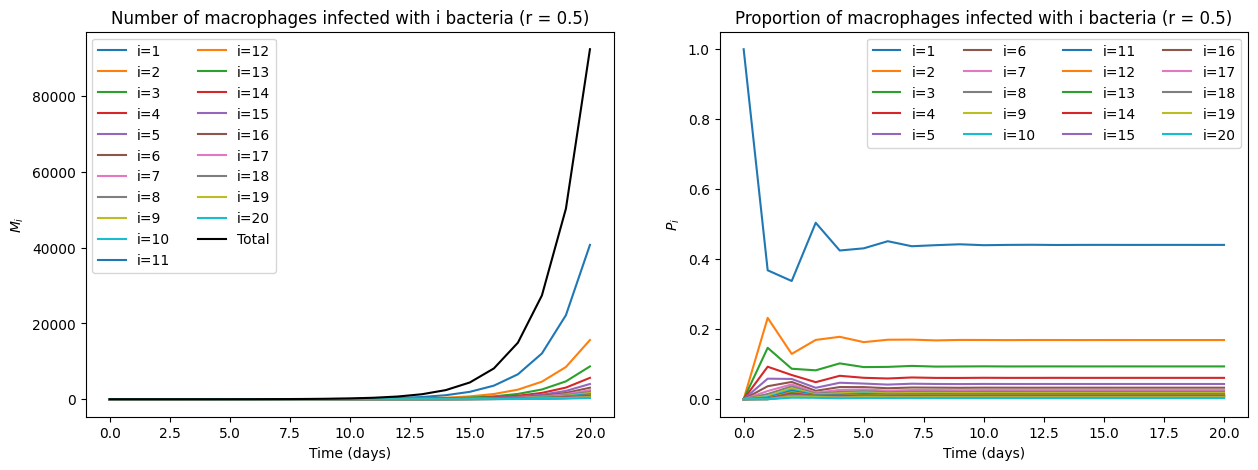

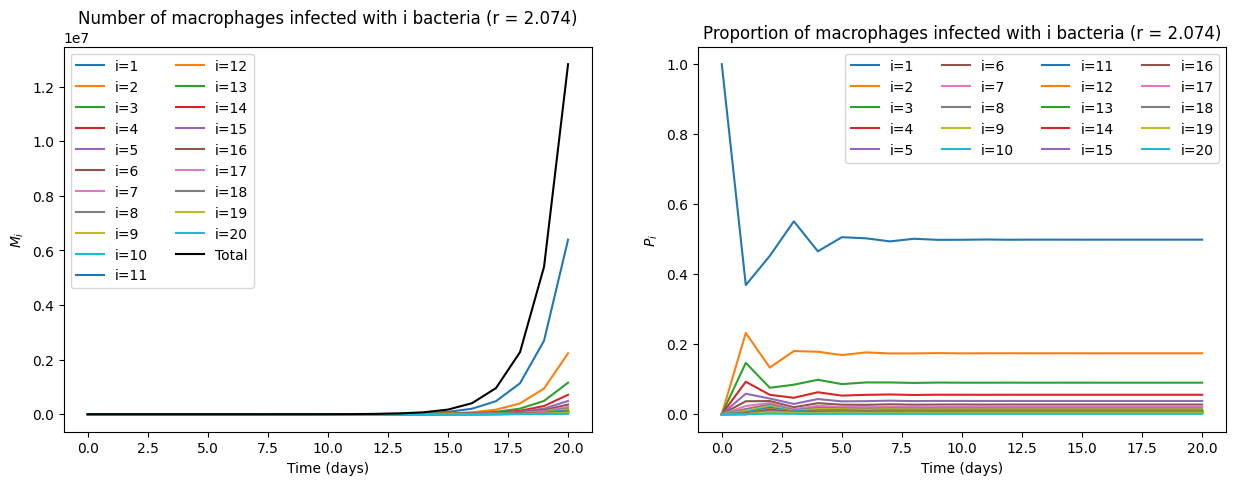

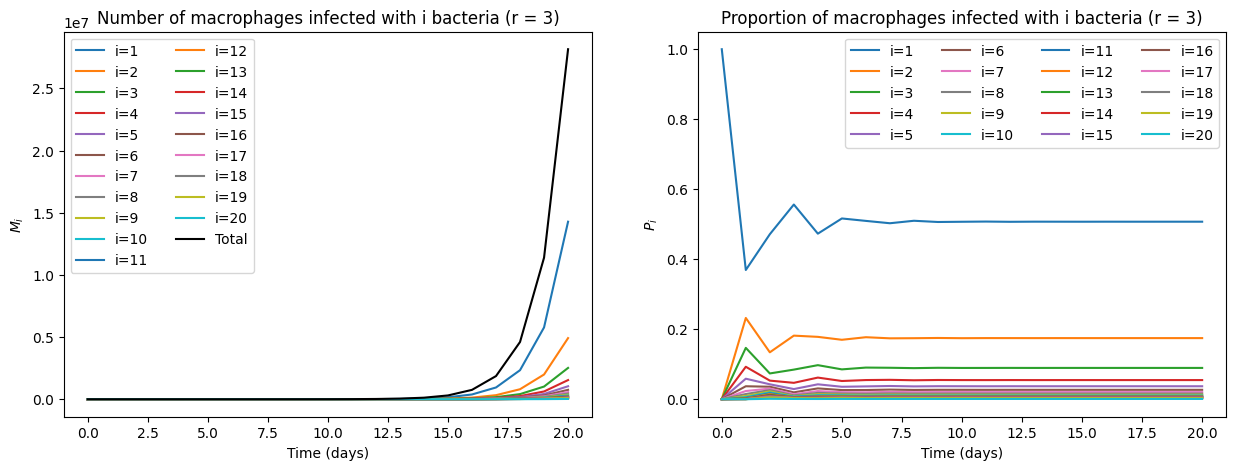

In [ ]:
N = 20
r_crude = np.log((10**6)/250) / 4
for r in [0.5, r_crude, 3]:
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  # initialise the starting condition
  M_0 = np.zeros(shape=(N+1,))
  M_0[1] = 1
  # initialise alpha vector
  alpha = np.ones(shape=(N+1,))
  alpha[0] = 0
  # initialise mu vector
  mu = np.zeros(shape=(N+1,))
  mu[N] = N*r
  # initialise beta vector
  beta = np.zeros(shape=(N+1,))
  beta[N] = N + 1

  # get output of ode_sol function
  Ms = ode_sol(alpha, mu, beta, M_0, max_time)

  # plot for each value of i for 1 <= i <= N
  for i in range(1, N+1):
    ax1.plot(Ms.t, Ms.y[i])

  # plot the total
  Y = []
  for j in range(len(Ms.t)):
    Y.append(sum([Ms.y[n][j] for n in range(len(Ms.y))]))
  ax1.plot(Ms.t, Y, color="black")
  ax1.set_title("Number of macrophages infected with i bacteria (r = " + str(round(r, 3)) + ")")
  ax1.set_xlabel("Time (days)")
  ax1.set_ylabel(r"$M_i$")
  legend_ls = ["i=" + str(k) for k in range(1, N+1)]
  legend_ls.append("Total")
  ax1.legend(legend_ls, loc='upper left', ncols=1 if N < 12 else 2)

  # plot the proportional population of cells infected by i bacteria
  P = np.zeros(shape=len(Ms.y[0]))
  for i in range(1, N+1):
    for j in range(len(Ms.y[i])):
        P[j] = Ms.y[i][j] / Y[j]
    ax2.plot(Ms.t, P)
  ax2.set_title("Proportion of macrophages infected with i bacteria (r = " + str(round(r, 3)) +")")
  ax2.set_xlabel("Time (days)")
  ax2.set_ylabel(r"$P_i$")
  ax2.legend(["i=" + str(k) for k in range(1, N+1)], loc='upper right', ncols=N//5)
  plt.show()

From these plots it is evident that changing the bacterial divison rate *r* changes the number of infected cells but not the proportions of cells infected with *i* bacteria. As we increase *r*, the number of cells infected with *i* bacteria increases for each value of *i* (evident by change in scale on y-axis), but the proportion of macrophages infected with *i* bacteria remains unchanged.

The rate at which a steady state is reached (in the plots of proportional populations) also seems to be unaffected by *r*, with all three plots appearing to take the same number of time increments to reach a steady state.

We will now interpret the array of proportions of cells containing $i$ bacteria, $P_i(t) = \frac{M_i(t)}{Y(t)}, \, 1 \leq i \leq N$, as the probability distribution of intracellular bacteria, to form a stochastic version of the model. Using numerical results previously obtained, check that the stationary distribution $\{\pi_i, 1 \leq i \leq N\}$ of $\{P_i(t), 1 \leq i \leq N\}$ satisfies:

$
\pi_i = \frac{N + 1}{i(i + 1)N}
$


Taking values of $P_i(t)$ at the end of the time range shown above (such that the graphs of $P_i(t)$ have reached a 'steady state'), the following graph can be plotted showing the relationship between the $π_i$ values suggested by the model above
and the $π_i$ values given by the expression
$π_i=\frac{N+1}{i(i+1)N}$, for each value of N.


For N = 5:
Slope = 0.907 
Intercept = 0.019 
r value = 0.997 

For N = 10:
Slope = 0.896 
Intercept = 0.01 
r value = 0.999 

For N = 20:
Slope = 0.905 
Intercept = 0.005 
r value = 0.999 



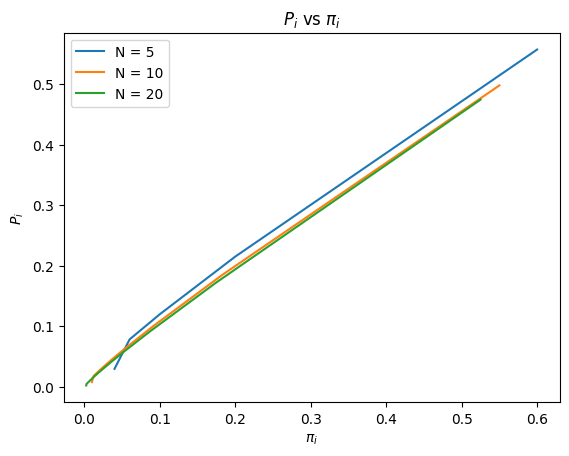

In [ ]:
from scipy import stats

for N in Ns:
  i_values = P_i_dict[N].keys()
  P_i_values = P_i_dict[N].values()
  pi_values = [(N+1)/(i*(i+1)*N) for i in i_values]
  plt.plot(pi_values, P_i_values)
  slope, intercept, rvalue, pvalue, stderr = stats.linregress(pi_values, [i for i in P_i_values])
  print("For N = " + str(N) + ":\n" + "Slope =", round(slope, 3), "\n" + "Intercept =", round(intercept, 3), "\n" + "r value =", round(rvalue, 3), "\n")
plt.legend(["N = " + str(n) for n in Ns])
plt.xlabel(r"$\pi_i$")
plt.ylabel(r"$P_i$")
plt.title(r"$P_i$ vs $\pi_i$")
plt.show()


Each line has a gradient of approximately 1, an intercept of approximately 0 (roughly $y=x$), and an r value of approximately 1. This suggests that the values $P_i(t)$ do follow the stationary distribution $π_i=\frac{N+1}{i(i+1)N}$, for each value of N.

Note that the index *i* is not explicitly shown on this graph. The value of index *i* increases along the length of each line shown (ascending from bottom left to top right).

# Section 2 - Experimental Data and Likelihood function

The data for this section is in the file “Brown_2006_data.csv” and lists the number of cells that contain 1, 2, 3 etc. bacteria in two experiments – one using a wildtype ‘virulent’ strain
and the other an ‘attenuated’ mutated strain of Salmonella. The data were collected by counting the bacteria in around 1,000 infected macrophages in the liver of mice on Day 4 post-inoculation.
The proportions were very similar to those on Day 3, hence we assume they represent the steady state of the distribution of intracellular bacteria.

The two distributions are plotted below.

In [ ]:
import csv

# read in Brown data
with open("Brown_2006_data.csv", 'r') as csv_file:
  reader = csv.reader(csv_file)
  bacteria_number = []
  attenuated = []
  virulent = []
  for row in reader:
    bacteria_number.append(row[0])
    attenuated.append(row[1])
    virulent.append(row[2])
  csv_file.close()

bacteria_number = [int(b) for b in bacteria_number[1:]] # first column of cvs file (removing title)
attenuated = [int(a) for a in attenuated[1:]] # second column
virulent = [int(v) for v in virulent[1:]] # third column

# get proportional data
P_attenuated = []
P_virulent = []
total_attenuated = sum(attenuated)
total_virulent = sum(virulent)
for i in range(len(bacteria_number)):
  P_attenuated.append(attenuated[i]/total_attenuated)
  P_virulent.append(virulent[i]/total_virulent)

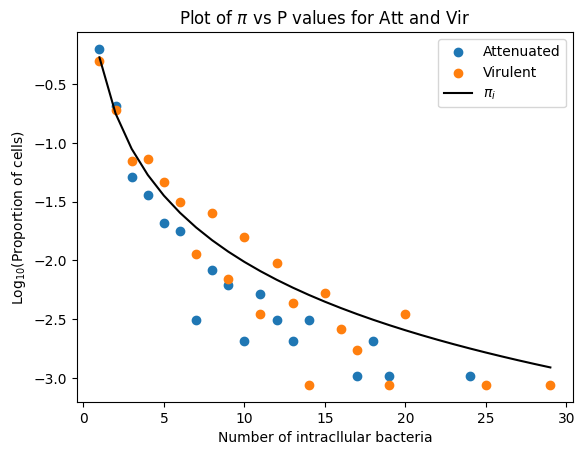

In [ ]:
N = 15
plt.scatter(bacteria_number, np.log10(np.array(P_attenuated)))
plt.scatter(bacteria_number, np.log10(np.array(P_virulent)))
pi_values = [(N+1)/(i*(i+1)*N) for i in range(1, 30)]
plt.plot(bacteria_number, np.log10(np.array(pi_values)), 'black')
plt.xlabel("Number of intracllular bacteria")
plt.ylabel(r"Log$_{10}$(Proportion of cells)")
plt.legend(["Attenuated", "Virulent", r"$\pi_i$"])
plt.title(r"Plot of $\pi$ vs P values for Att and Vir")
plt.show()


This suggests that the distribution of intracellular bacteria does approximately follow the stationary distribution stated above. The virulent strain has approximately the same number of data points above and below the line corresponding to the derived stationary distribution, whereas the attenuated strain data appears to sit mostly below the line. This suggests that the derived stationary distribution fits the virulent data relatively well, whilst overestimating the distribution of attenuated intracellular bacteria.  

## Likelihood function

$L(π) = X!∏_{n≥1}\frac{{π_N}^{X_n}}{{X_n}!}$

Taking the natural log of both sides gives:

$ln(L(\pi)) = ∑_{k≥1}^{X}ln(k) + ∑_{n≥1}[X_{n}ln(π_n) - ∑_{m≥1}^{X_n}ln(m)]$

This formula will be used to calculate the log likelihood, as attempting to calculate the likelihood and then taking the log results in an error as the numbers get too large.

In [ ]:
def log_lik(pi, obs):
  X = sum(obs)
  # calculate log of the first factorial term (X!):
  log_L = sum(np.log(x) for x in range(1, X+1))
  # add log of terms inside product
  for i in range(len(pi)): # further terms would not contribute to the log likelihood
    X_n = obs[i]
    pi_n = pi[i]
    log_L = log_L + X_n * np.log(pi_n) - sum([np.log(n) for n in range(1, X_n + 1)])
  return log_L


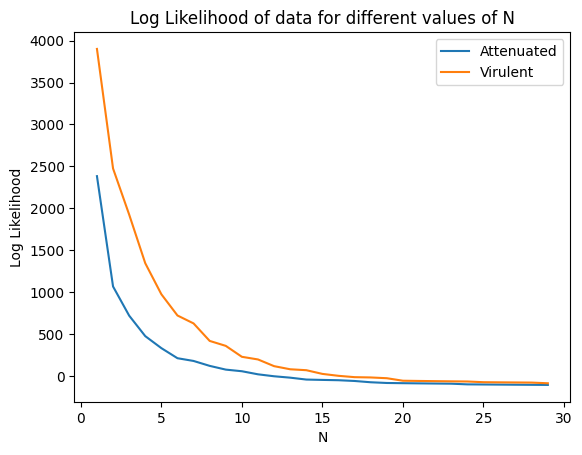

In [ ]:
# plot log likelihood of data from each strain for varying values of N
N_values = range(1, 30)
log_lik_att = []
log_lik_vir = []
for N in N_values:
  pi = [(N+1)/(i*(i+1)*N) for i in range(1, N+1)]
  log_lik_att.append(log_lik(pi, attenuated))
  log_lik_vir.append(log_lik(pi, virulent))
plt.plot(N_values, log_lik_att)
plt.plot(N_values, log_lik_vir)
plt.xlabel("N")
plt.ylabel("Log Likelihood")
plt.title("Log Likelihood of data for different values of N")
plt.legend(["Attenuated", "Virulent"])
plt.show()

The log likelihood is higher for the virulent strain for all values of *N*, suggesting that this model describes the dynamics of the virulent strain better than the attenuated strain.

For both strains, the log likelihood is highest for lower values of *N*. This is not the result that we would expect. A more logical hypothesis (when using a fixed burst size) is that there would be a value of *N* for which log likelihood is maximised. This unexpected result is due to the design of the log likelihood function. As $π_{i}$ takes values for 1 ≤ *i* ≤ *N*, the log likelihood function which takes the π array as a parameter can only use the first *N* observed data points (this comes from the *len(pi)* in the *log_lik* function). Therefore, the log likelihood calculated for *N*=1 only uses the observed number of macrophages that contain 1 bacterial cell, and ignores the rest of the data. Therefore it is not surprising that we see a higher log likelihood for lower values of *N*, as the log likelihood function is only using *N* data points.

If we were instead to let $π_i$ to equal 0 for *i*>*N*, then the **likelihood** would be zero for all values of *N*<29. This makes intuitive sense as if we say that a macrophage will definitely burst when it contains more than *N* intracellular bacteria, then the probability of containing more than *N* bacteria is 0, and so the observed data is impossible for values of *N* smaller than the highest number of intracellular bacteria in a macrophage (and so likelihoood = 0).

# Section 3 - Stochastic Lysis Rate (Model B)

A cell containing $i$ bacteria has a probability $δ_i$ of bursting and $(1 - δ_i)$ of surviving to the next bacterial division event. As a result, the bacterial division rate in cells of size $i$ is $\alpha_i = r (1 - δ_i)$, the lysis rate is $\mu_i = r i δ_i$, and the burst size is $\beta_i = i + 1$.

$
\frac{dM_1}{dt} = -r_1 M_1 + \sum_{i\ge1} (i + 1) i r δ_i M_i
$

$
\forall i > 1, \quad \frac{dM_i}{dt} = (i - 1)(1 - δ_i) r M_{i-1} - i r M_i
$

Besides the maximum bacterial load $N$ and the intrinsic bacterial division rate $r$, Model B is defined by the vector of lysis probabilities $\{δ_i, 1 \leq i \leq N\}$. From a biological perspective, it is more useful to consider the probability distribution of lysis sizes $N_b$, the number of bacteria in a cell undergoing lysis. We can define the probability that a newly infected cell will reach a bacterial load $n$ before bursting as:

$
B_n = P(N_b = n) = δ_n \prod_{i<n} (1 - δ_j)
$

As before, for ease of coding, we assume that $δ_0 = 0$. Provided that we impose $δ_N = 1$, the expression above satisfies

$
\sum_{0\le n \le N} B_n = 1
$

The relation can be reversed to derive the lysis probabilities $δ_i$ given the distribution $\{B_n, 0 \leq n \leq N\}$:

$
δ_i = \frac{B_i}{\sum_{n \geq i} B_n}
$

Model A is now a special case of Model B where $δ_N = 1$ and $δ_i = 0 \, \forall i < N$.

It can then be shown that the stationary distribution $\pi = \{\pi_i, 1 \leq i \leq N\}$ of intracellular bacteria for Model B is given by:

$
\pi_i = \frac{\sum_{n \geq i} B_n}{Ci(i + 1)} = \frac{1 - \sum_{n < i} B_n}{Ci(i + 1)}, \quad 1 \leq i \leq N
$

where $C$ is a normalizing constant such that $\sum_{i} \pi_i = 1$. As before, for coding purposes, we can include an initial element $\pi_0 = 0$.

For now, we will consider a particular case of Model B where the bursting probability is independent of the bacterial load: $δ_i = δ ,\, \forall 0 < i < N$, $δ_0 = 0$, and $δ_N = 1$.


The function stat_B is defined to return the stationary distribution π
for a given value of δ and N.

$δ_i$ represents the probability of a cell bursting when it contains *i* bacteria.


In [ ]:
def stat_B(delta, N):
  pi_values = [0]
  Bs = []
  for i in range(1, N):
    Bs.append(delta * (1-delta)**(i-1))
    pi_values.append((1 - sum(Bs))/(i*(i + 1)))
  Bs.append(1 *(1-delta)**(N-1))
  pi_values.append((1 - sum(Bs))/(N*(N+1)))
  tot = sum(pi_values)
  out = [pi/tot for pi in pi_values]
  return out


This stationary distribution should match the stationary distribution from Model A for δ = 0. This can be confirmed for a range of values of N.

For N = 10 stat_B(0, N) DOES numerically match the stationary distribution from Model A (to 1 d.p.)
For N = 15 stat_B(0, N) DOES numerically match the stationary distribution from Model A (to 1 d.p.)
For N = 20 stat_B(0, N) DOES numerically match the stationary distribution from Model A (to 1 d.p.)
For N = 25 stat_B(0, N) DOES numerically match the stationary distribution from Model A (to 1 d.p.)
For N = 30 stat_B(0, N) DOES numerically match the stationary distribution from Model A (to 1 d.p.)




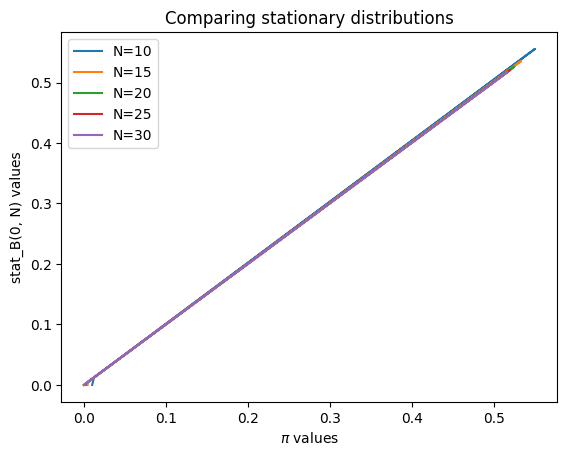

In [ ]:
for N in range(10, 31, 5):
  # redefining pi values to compare with
  pi_values = [(N+1)/(i*(i+1)*N) for i in range(1, N+1)]
  pi_values.insert(0, 0.0) # add 0.0 at index 0
  S_B = stat_B(0, N)
  plt.plot(pi_values, S_B)

  distribution_match = True
  for i in range(len(pi_values)):
    if round(pi_values[i], 1) != round(S_B[i], 1): # 1 decimal place
      distribution_match = False
  if distribution_match:
    print("For N =", N, "stat_B(0, N) DOES numerically match the stationary distribution from Model A (to 1 d.p.)")
  else:
    print("For N =", N, "stat_B(0, N) DOES NOT numerically match the stationary distribution from Model A")

print("\n")
plt.legend(["N=" + str(i) for i in range(10, 31 ,5)], loc='upper left')
plt.xlabel(r"$\pi$ values")
plt.ylabel("stat_B(0, N) values")
plt.title("Comparing stationary distributions")
plt.show()




This suggests that stationary distribution given by δ = 0 does match the stationary distribution from model A.

The mean number of intracellular bacteria can then be plotted against varying values of δ:

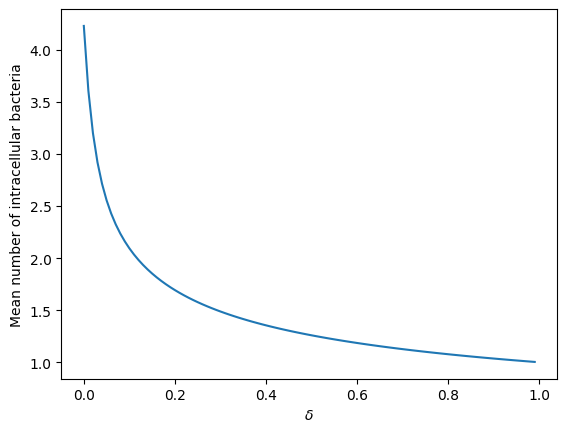

In [ ]:
bact_number = []
N = 100
for n in range(0, N):
  delta = n/N
  values = stat_B(delta, N)
  n_bact = 0
  for k in range(len(values)):
    n_bact += k*values[k]
  bact_number.append(n_bact)

plt.plot([i/N for i in range(0, N)], bact_number)
plt.xlabel(r"$\delta$")
plt.ylabel("Mean number of intracellular bacteria")
plt.show()


A maximum likelihood estimate for the bursting probability δ can be calculated for each strain of bacteria (setting N=100).

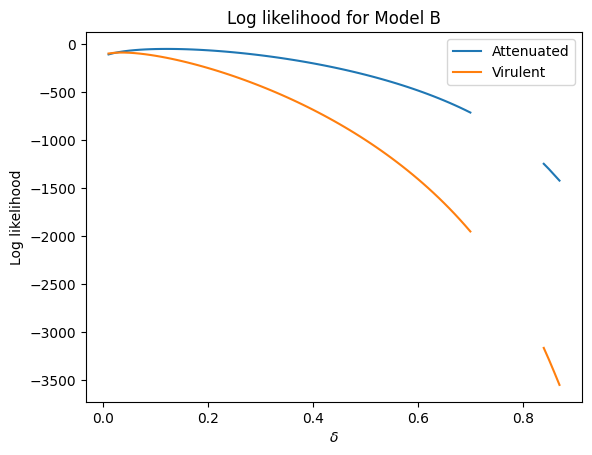

ATTENUATED:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 51.901567309499896
             x: [ 1.209e-01]
           nit: 12
          nfev: 24
 final_simplex: (array([[ 1.209e-01],
                       [ 1.209e-01]]), array([ 5.190e+01,  5.190e+01]))


VIRULENT:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 89.51971205151834
             x: [ 3.531e-02]
           nit: 15
          nfev: 30
 final_simplex: (array([[ 3.531e-02],
                       [ 3.523e-02]]), array([ 8.952e+01,  8.952e+01]))


In [ ]:
from scipy.optimize import minimize

def tmp_fun(delta, N, obs):
  pi_values = stat_B(delta, N)[1:len(obs)+1]
  return -log_lik(pi_values, obs) # use negative as we can only minimize a function not maximize it

# plot log likelihood to find starting value to enter into minimize function
Ds = []
att = []
vir = []
N = 100
for D in range(1, N):
  d = D/N
  Ds.append(d)
  pi_values = stat_B(d, N)
  att.append(log_lik(pi_values[1:len(attenuated)+1], attenuated))
  vir.append(log_lik(pi_values[1:len(virulent)+1], virulent))
plt.plot(Ds, att)
plt.plot(Ds, vir)
plt.title("Log likelihood for Model B")
plt.ylabel("Log likelihood")
plt.xlabel(r"$\delta$")
plt.legend(["Attenuated", "Virulent"])
plt.show()

# graph (below) shows maxima around 0.2
w = minimize(tmp_fun, [0.2], args=(N, attenuated), method='Nelder-Mead')
print("ATTENUATED:")
print(w)
print("\n")
v = minimize(tmp_fun, [0.2], args=(N, virulent), method='Nelder-Mead')
print("VIRULENT:")
print(v)


Both optimizations terminated successfully, with x values matching those seen in the graph above.


We can now calculate Wilk's confidence interval:

In [ ]:
threshold_attenuated = -w.fun - 1.92
threshold_virulent = -v.fun -1.92

att_interval = []
vir_interval = []
for i in range(1, 1000):
  delta = i/1000
  pi_values = stat_B(delta, N)
  if log_lik(pi_values[1:len(attenuated)+1], attenuated) >= threshold_attenuated:
    att_interval.append(delta)
  if log_lik(pi_values[1:len(virulent)+1], virulent) >= threshold_virulent:
    vir_interval.append(delta)

print("Wilk's confidence interval for the ATTENUATED strain:", min(att_interval), "< \u03B4 <", max(att_interval))
print("Wilk's confidence interval for the VIRULENT strain:", min(vir_interval), "< \u03B4 <", max(vir_interval))

Wilk's confidence interval for the ATTENUATED strain: 0.096 < δ < 0.148
Wilk's confidence interval for the VIRULENT strain: 0.024 < δ < 0.048


As neither of these intervals contain 0, it is clear that the δ parameter has a non-zero impact on the data, suggesting that this model is somewhat appropriate.

The observed and predicted distributions of intracellular bacteria can then be plotted for each strain.

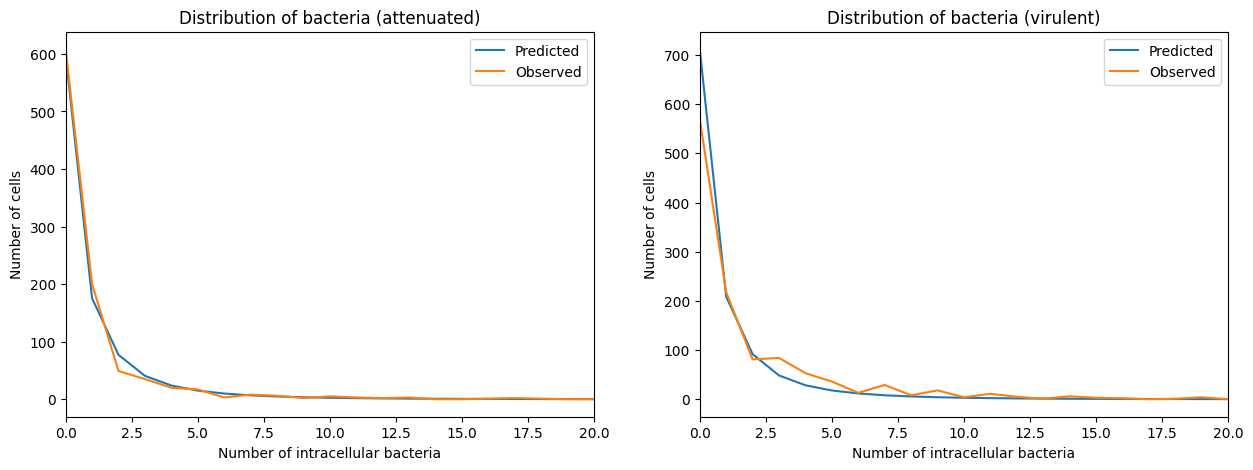

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# attenuated
pi_values = stat_B(w.x[0], N)
total = sum(attenuated)
predicted = [pi*total for pi in pi_values]

ax1.plot(predicted[1:])
ax1.plot(attenuated)
ax1.set_title("Distribution of bacteria (attenuated)")
ax1.legend(["Predicted", "Observed"])
ax1.set_xlabel("Number of intracellular bacteria")
ax1.set_ylabel("Number of cells")
ax1.set_xlim(0, 20)

# virulent
pi_vals = stat_B(v.x[0], N)
tot = sum(virulent)
pred = [pi*tot for pi in pi_values]
ax2.plot(pred[1:])
ax2.plot(virulent)
ax2.set_title("Distribution of bacteria (virulent)")
ax2.legend(["Predicted", "Observed"])
ax2.set_xlabel("Number of intracellular bacteria")
ax2.set_ylabel("Number of cells")
ax2.set_xlim(0, 20)
plt.show()

The observed distribution closely follows the prediction distribution for both strains, suggesting that the model is appropriate. It appears that the observed data more closely follows the predicted distribution for the attenuated strain, suggesting that model B better describes the behaviour of the attenuated strain.

# Section 4 - Poisson distributed lysis size (model C)

Model C is another particular case of Model B where the lysis sizes $q_n$ follow a truncated Poisson distribution with mean $\lambda$:

$
B_n = \frac{\lambda^{n} e^{-\lambda}}{n!}, \quad 1 \leq n < N
$

$
B_N = 1 - \sum_{1 \leq n \leq N} B_n
$


We will now calculate the maximum likelihood estimate of the mean burst size λ using model C (a Poisson distributed lysis size).

In [ ]:
def pois_model(lam, N):
  pi_values = [0]
  sum = 0
  for n in range(1, N):
    B_n = (np.exp(-lam) * lam**n)/np.math.factorial(n)
    sum = sum + B_n
    pi = (1 - sum)/(n*(n+1)) # the n(n+1) term has changed the graph from looking good to not
    pi_values.append(np.float64(pi)) # need float64 as minimisation wasn't working wihtout
  pi_values = np.array(pi_values)
  pi_values = pi_values/np.sum(pi_values)
  return pi_values

The log likelihood can be plotted against lambda to find initial guesses for the minimize function.

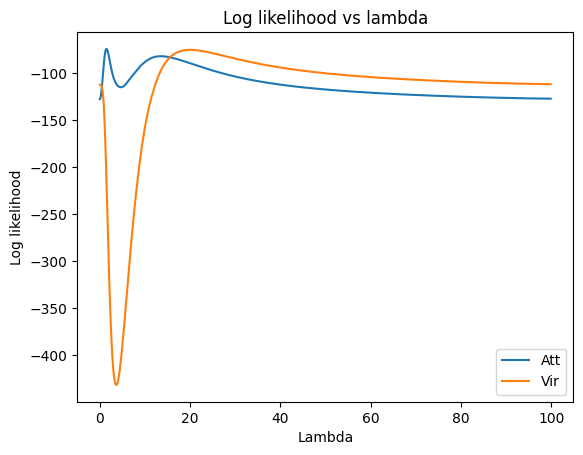

In [ ]:
att = []
vir = []
lams = []
N = 100
for L in range(0, 10000, 10):
  lam = L/100
  lams.append(lam)
  pi_vals = pois_model(lam, N)
  att.append(log_lik(pi_vals[1:len(attenuated)+1], np.array(attenuated)))
  vir.append(log_lik(pi_vals[1:len(virulent)+1], virulent))

plt.plot(lams, att)
plt.plot(lams, vir)
plt.title("Log likelihood vs lambda")
plt.xlabel("Lambda")
plt.ylabel("Log likelihood")
plt.legend(["Att", "Vir"])
plt.show()


From this graph it appears that the (hopefully) global maxima occur at around 1 < λ < 2 and 18 < λ < 21 for attenuated and virulent respectively. We will use these for initial guesses in the minimize function.


In [ ]:
# define temporary function to enter into minimize function
def tmp_fun2(lam, N, obs):
  pi_values = pois_model(lam, N)[1:len(obs)+1]
  return -log_lik(pi_values, obs)

f = minimize(tmp_fun2, [2], args=(N, attenuated), method='Nelder-Mead')
print("ATTENUATED:")
print(f)
print("\n")
g = minimize(tmp_fun2, [19], args=(N, virulent), method='Nelder-Mead')
print("VIRULENT")
print(g)

ATTENUATED:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 74.17514418110575
             x: [ 1.473e+00]
           nit: 15
          nfev: 30
 final_simplex: (array([[ 1.473e+00],
                       [ 1.473e+00]]), array([ 7.418e+01,  7.418e+01]))


VIRULENT
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 75.1683405777653
             x: [ 2.000e+01]
           nit: 15
          nfev: 30
 final_simplex: (array([[ 2.000e+01],
                       [ 2.000e+01]]), array([ 7.517e+01,  7.517e+01]))


Both optimizations terminated successfully, and the x values appear to be correct based on our estimates from the graph above. Note that the log likelihoods (which are equal to the negative of the value after 'fun:') are similar to those calculated using Model B.

These values of λ can then be used to compare predicted data to the data observed.

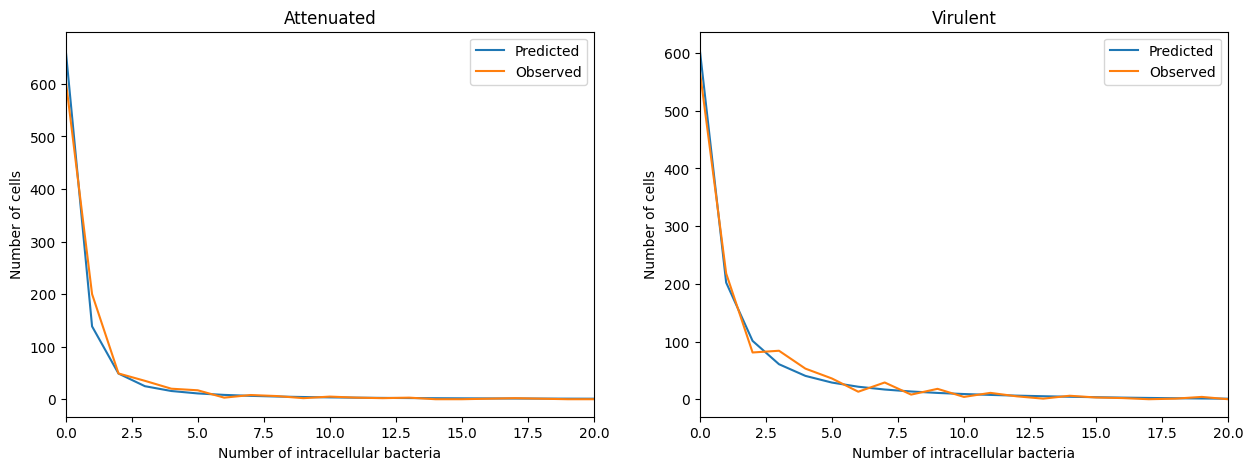

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

lam = f.x[0]
pi_values = pois_model(lam, N)
tot = sum(attenuated)
predicted = [pi*tot for pi in pi_values]
ax1.plot(predicted[1:])
ax1.plot(attenuated)
ax1.set_xlim(0, 20)
ax1.set_title("Attenuated")
ax1.set_xlabel("Number of intracellular bacteria")
ax1.set_ylabel("Number of cells")
ax1.legend(["Predicted", "Observed"])

lam = g.x[0]
pi_values = pois_model(lam, N)
tot = sum(virulent)
predicted = [pi*tot for pi in pi_values]
ax2.plot(predicted[1:])
ax2.plot(virulent)
ax2.set_xlim(0, 20)
ax2.set_title("Virulent")
ax2.set_xlabel("Number of intracellular bacteria")
ax2.set_ylabel("Number of cells")
ax2.legend(["Predicted", "Observed"])
plt.show()

This suggests that this model is appropriate as, for both strains, the observed distribtution closely follows the distribution predicted by the model. As was the case for model B, the observed data for the attenuated strain more closely follows the predicted distribution.

In [ ]:
att_threshold = -f.fun - 1.92
vir_threshold = -g.fun -1.92

att_interval = []
vir_interval = []
for i in range(1, 2500):
  lam = i/100
  pi_values = pois_model(lam, N)
  if log_lik(pi_values[1:len(attenuated)+1], attenuated) >= att_threshold:
    att_interval.append(lam)
  if log_lik(pi_values[1:len(virulent)+1], virulent) >= vir_threshold:
    vir_interval.append(lam)

print("Wilk's confidence interval for the ATTENUATED strain:", min(att_interval), "< \u03BB <", max(att_interval))
print("Wilk's confidence interval for the VIRULENT strain:", min(vir_interval), "< \u03BB <", max(vir_interval))

Wilk's confidence interval for the ATTENUATED strain: 1.26 < λ < 1.71
Wilk's confidence interval for the VIRULENT strain: 17.53 < λ < 23.39


Again, as these intervals do not contain 0, it is clear that the parameter λ has a non-zero impact on the data.

Akaike's Information Criterion can then be used to compare Models B (in part 3) and C (in part 4) for each strain.

$AIC=2K - 2ln(L)$

Where K is the number of independent parameters used in the model and L is the likelihood (so $ln(L)$ is the log likelihood. For Model B, only one parameter is used in the model so we will use K = 3 (as K = 2 is the default). For Model C we will use K = 4.

In [ ]:
k_B = 1
k_C = 1
# ATTENUATED
print("ATTENUATED:")
AIC_att_B = 2*k_B + 2*w.fun
AIC_att_C = 2*k_C + 2*f.fun
print("Model B:", round(AIC_att_B, 3))
print("Model C:", round(AIC_att_C, 3), "\n")

# VIRULENT
print("VIRULENT:")
AIC_vir_B = 2*k_B + 2*v.fun
AIC_vir_C = 2*k_C + 2*g.fun
print("Model B:", round(AIC_vir_B, 3))
print("Model C:", round(AIC_vir_C, 3))

ATTENUATED:
Model B: 105.803
Model C: 150.35 

VIRULENT:
Model B: 181.039
Model C: 152.337


Now using AICc as there is a relatively low number of observations.

In [ ]:
n = 29
k_B = 1
k_C = 1
# ATTENUATED
print("ATTENUATED:")
AICc_att_B = AIC_att_B + (2*k_B*(k_B+1))/(n-k_B-1)
AICc_att_C = AIC_att_C + (2*k_C*(k_C+1))/(n-k_C-1)
print("Model B:", round(AICc_att_B, 3))
print("Model C:", round(AICc_att_C, 3), "\n")

# VIRULENT
print("VIRULENT:")
AICc_vir_B = AIC_vir_B + (2*k_B*(k_B+1))/(n-k_B-1)
AICc_vir_C = AIC_vir_C + (2*k_C*(k_C+1))/(n-k_C-1)
print("Model B:", round(AICc_vir_B, 3))
print("Model C:", round(AICc_vir_C, 3))

ATTENUATED:
Model B: 105.951
Model C: 150.498 

VIRULENT:
Model B: 181.188
Model C: 152.485


In both cases, it is suggested that model B is more appropriate than model C for describing the dynamics of the attenuated strain. The AIC value for model C is approximately 1.4 times larger than that of model B.

In contrast, model C appears to be more appropriate for describing the dynamics of the virulent strain, with the AIC value for model B being approximately 1.2 times larger than that of model C.

It is also noteable that the log likelihood values corresponding to the attenuated and virulent strain are approximately the same using model C (74.2 and 75.2 respectively), whereas there is a significant different in log likelihood when using model B (51.9 and 89.5 respectively). We may have expected (as a null hypothesis) that the burst sizes for different strains of bacteria would follow the same distribution, albeit with different parameter values. It may be worth fitting out models to more experimental data to see if the results seen above are reproducible. If it is found that the two strains do infact have burst sizes that come from different distributions, it may be interesting to investigate the biological differences that give this result.